I processed the new SI measurements based on VLBI images from astrogeo. 

These results will be used to complement those available in the BVID database.

In [1]:
from astropy.table import Table, setdiff, join, vstack
from astropy.time import Time
# import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np

In [2]:
def epoch_convert(epoch_str):
    """Convert XXXX_XX_XX into XXXX-XX-XX
    """
    
    epoch_str_new = epoch_str.replace("_", "-")
    
    return epoch_str_new

In [3]:
si_x_table = Table.read("../data/astrogeo_SI.txt", format="ascii")

Convert the epoch from string into `astropy.time.Time` type.

In [4]:
new_epoch_str = [epoch_convert(epoch_str) for epoch_str in si_x_table["Epoch"]]

epoch = Time(new_epoch_str, scale="utc")
si_x_table["Epoch"] = epoch.jyear

In [5]:
si_x_table.rename_columns(["Source", "IERS_name", "Epoch", "SI", "Band"],
                          ["j2000_name", "iers_name", "year", "si", "band"])

In [6]:
# Table of 512 sources
com_sou_list = Table.read("../data/com-sou-list.txt", format="ascii")
# com_sou_list2 = Table.read("../data/com-sou-list-DR2.txt", format="ascii")

# Cross-match
si_4_com_sou = join(si_x_table, com_sou_list, keys="iers_name")

# To see how many sources are given a SI measurement
si_4_com_sou_g = si_4_com_sou.group_by("iers_name")

com_sou_with_si = si_4_com_sou_g.groups.keys
print(len(com_sou_with_si), "sources are gvien the SI seasurements.")

196 sources are gvien the SI seasurements.


In [7]:
num_sou_with_si = len(com_sou_with_si)
num_si = np.zeros(num_sou_with_si)
med_si = np.zeros(num_sou_with_si)
std_si = np.zeros(num_sou_with_si)
si_dif = np.zeros(num_sou_with_si)
med_epo = np.zeros(num_sou_with_si)
epo_dif = np.zeros(num_sou_with_si)
si_val = np.zeros(num_sou_with_si)
epo_si_val = np.zeros(num_sou_with_si)
epo_to_2015 = np.zeros(num_sou_with_si)

for i, group in enumerate(si_4_com_sou_g.groups):
    num_si[i] = len(group)

    if len(group) == 1:
        std_si[i] = 0
    else:
        std_si[i] = np.std(group["si"])

    med_si[i] = np.median(group["si"])
    med_epo[i] = np.median(group["year"])

    si_dif[i] = group["si"].max() - group["si"].min()
    epo_dif[i] = group["year"].max() - group["year"].min()

    dif_2015 = np.fabs(group["year"] - 2015)

    ind = dif_2015.argmin()
    si_val[i] = group["si"][ind]
    epo_si_val[i] = group["year"][ind]
    epo_to_2015[i] = dif_2015[ind]

si_sta = Table([
    com_sou_with_si["iers_name"], num_si, std_si, si_dif, epo_dif, si_val,
    epo_to_2015
],
               names=[
                   "iers_name", "nb_si", "si_std", "si_dif", "epo_dif", "si",
                   "epo_2_2015"
               ])

#Sou with only one SI measurements are 72.0


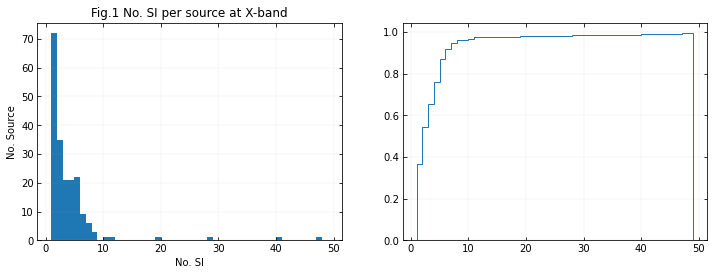

In [8]:
fig, (ax0, ax1) = plt.subplots(figsize=(12, 4), ncols=2, sharex=True)

bins = np.arange(1, 50)

cou, _, _ = ax0.hist(si_sta["nb_si"], bins)
ax0.set_xlabel("No. SI")
ax0.set_ylabel("No. Source")
ax0.set_title("Fig.1 No. SI per source at X-band")
ax0.grid(lw=0.1)

num = len(si_sta)
ax1.hist(si_sta["nb_si"], bins, histtype="step", cumulative=True, weights=np.ones(num)/num)
ax1.grid(lw=0.1)

print("#Sou with only one SI measurements are", cou[0])

Fig.2 Standard deviation of SI at X-band (Astrogeo)


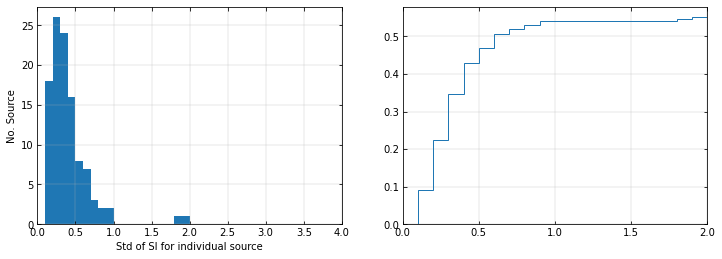

In [9]:
fig, (ax0, ax1) = plt.subplots(figsize=(12, 4), ncols=2, sharex=True)

bins = np.arange(0.1, 4, 0.1)
cou_s, _, _ = ax0.hist(si_sta["si_std"], bins)

ax0.set_xlabel("Std of SI for individual source")
ax0.set_ylabel("No. Source")
ax0.set_xlim([0, 2])
ax0.set_xticks(np.arange(0, 4.1, 0.5))
ax0.grid(lw=0.3)

num = len(si_sta["si_std"])
ax1.hist(si_sta["si_std"], bins, histtype="step", cumulative=True, weights=np.ones(num)/num)
ax1.grid(lw=0.3)

print("Fig.2 Standard deviation of SI at X-band (Astrogeo)")

Fig.3 Maximum absolute difference in SI at X-band (Astrogeo)


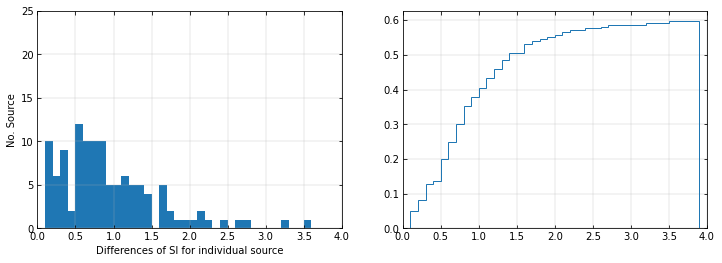

In [10]:
fig, (ax0, ax1) = plt.subplots(figsize=(12, 4), ncols=2, sharex=True)

bins = np.arange(0.1, 4, 0.1)
cou_s, _, _ = ax0.hist(si_sta["si_dif"], bins)

ax0.set_xlabel("Differences of SI for individual source")
ax0.set_ylabel("No. Source")
ax0.set_xlim([0, 4])
ax0.set_xticks(np.arange(0, 4.1, 0.5))
ax0.set_ylim([0, 25])
ax0.grid(lw=0.3)

num = len(si_sta["si_dif"])
ax1.hist(si_sta["si_dif"], bins, histtype="step", cumulative=True, weights=np.ones(num)/num)
ax1.grid(lw=0.3)

print("Fig.3 Maximum absolute difference in SI at X-band (Astrogeo)")

Fig.4 Epoch difference of image (Astrogeo)


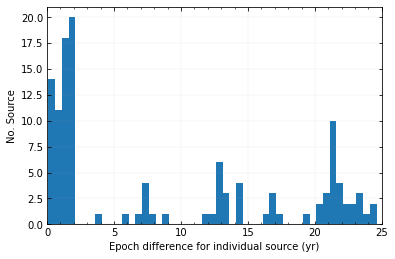

In [11]:
fig, ax = plt.subplots()

bins = np.arange(0.1, 25, 0.5)
cou_s, _, _ = ax.hist(si_sta["epo_dif"], bins)

ax.set_xlabel("Epoch difference for individual source (yr)")
ax.set_ylabel("No. Source")

ax.set_xlim([0, 25])
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.grid(lw=0.1)

print("Fig.4 Epoch difference of image (Astrogeo)")

Fig.5 Epoch difference to J2015 (Astrogeo)


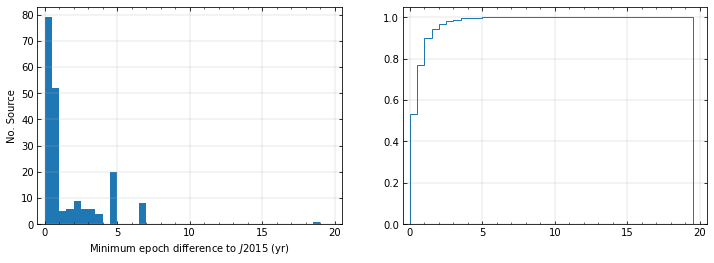

In [12]:
fig, (ax0, ax1) = plt.subplots(figsize=(12, 4), ncols=2, sharex=True)

bins = np.arange(0, 20, 0.5)
cou_s, _, _ = ax0.hist(si_sta["epo_2_2015"], bins)

ax0.set_xlabel("Minimum epoch difference to $J2015$ (yr)")
ax0.set_ylabel("No. Source")
ax0.set_xlim([-0.5, 20.5])
ax0.set_xticks(np.arange(0, 20.1, 5))
ax0.xaxis.set_minor_locator(MultipleLocator(1))
ax0.grid(lw=0.3)

num = len(si_sta["si_dif"])
ax1.hist(si_sta["si_dif"], bins, histtype="step", cumulative=True, weights=np.ones(num)/num)
ax1.grid(lw=0.3)

print("Fig.5 Epoch difference to J2015 (Astrogeo)")

In [13]:
# Store the results
si_tab_astro = Table(
    [com_sou_with_si["iers_name"], med_si, med_epo, si_val, epo_si_val],
    names=["iers_name", "si_med", "epo_med", "si_c15", "epo_c15"])

si_tab_astro.write("../data/si_from_astrogeo.fits", overwrite=True)

Compare with the one from BVID.

In [14]:
si_tab_bvid = Table.read("../data/si_from_bvid.fits")

Any common sources between these two tables?

In [15]:
com_sou = join(si_tab_bvid, si_tab_astro, keys="iers_name", table_names=["B", "A"])

I found 95 common sources.

Text(0, 0.5, 'SI from Astorgeo')

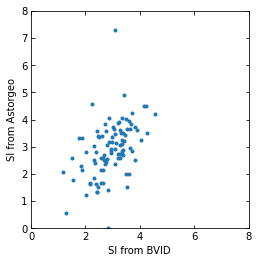

In [16]:
fig, ax = plt.subplots()

ax.plot(com_sou["si_c15_B"], com_sou["si_c15_A"], ".")

ax.axis("square")
ax.axis([0, 8, 0, 8])

ax.set_xlabel("SI from BVID")
ax.set_ylabel("SI from Astorgeo")

Text(0, 0.5, 'SI from Astorgeo')

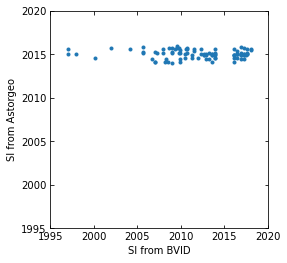

In [17]:
fig, ax = plt.subplots()

ax.plot(com_sou["epo_c15_B"], com_sou["epo_c15_A"], ".")

ax.axis("square")
ax.axis([1995, 2020, 1995, 2020])

ax.set_xlabel("SI from BVID")
ax.set_ylabel("SI from Astorgeo")

In [18]:
com_sou_list = Table([com_sou["iers_name"]])

Construct two SI tables:

- A: mainly based on the BVID table

- B: mainly based on the Astrogeo table

In [19]:
tmp = setdiff(si_tab_astro, com_sou_list, keys="iers_name")

si_tab_A = vstack((si_tab_bvid, tmp))

si_tab_A.write("../data/si_table_A.fits", overwrite=True)

In [20]:
tmp = setdiff(si_tab_bvid, com_sou_list, keys="iers_name")

si_tab_B = vstack((si_tab_astro, tmp))

si_tab_B.write("../data/si_table_B.fits", overwrite=True)